# Predicting Network Anomalies: Model Evaluation

We use the data and the labels generated in step 1 to build and evaluate the performance of multiple models to predict network degradation as it is identified in the labels. 

## Imports

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
from datetime import datetime, timedelta

In [2]:
clean_data = pd.read_csv("clean_labeled.csv")

labels = clean_data["predictions"]
df = clean_data.drop(columns=['basic_ema_anomaly', 'dspot_anomaly', 'tuned_dspot_anomaly'])#, 'predictions'])

In [25]:
list(clean_data.columns)

['Unnamed: 0',
 'ping_jitter',
 'ping_latency',
 'ping_low',
 'ping_high',
 'hostname',
 'date',
 'predictions',
 'basic_ema_anomaly',
 'dspot_anomaly',
 'tuned_dspot_anomaly']

In [3]:
# hostdf = df[df['hostname'] == '33fe84e'].copy()
# hostdf["date"] = pd.to_datetime(hostdf["date"])
# hostdf = hostdf.sort_values(by='date', ascending=True)
# hostdf['time_diff'] = hostdf['date'] - (hostdf['date'].shift(1))
# mask = (hostdf['time_diff'] > timedelta(hours=2)) #& (hostdf['time_diff'] <= timedelta(hours=3, minutes=15))
# filtered_results = hostdf[mask]['time_diff'].value_counts()

# # filtered_results
# hostdf.iloc[:120].head(30)

Filtering out 10 Second Time Deltas

In [4]:
# hostdf = df[df['hostname'] == '33fe84e'].copy()
# hostdf["date"] = pd.to_datetime(hostdf["date"])
# hostdf = hostdf.sort_values(by='date', ascending=True)
# hostdf['time_diff'] = hostdf['date'] - (hostdf['date'].shift(1))
# mask = (hostdf['time_diff'] >= timedelta(hours=2, minutes=15))
# three_hour_filtered_results = hostdf[mask]['time_diff'].value_counts()
# filtered_host_df = hostdf[mask]
# # filtered_results
# filtered_host_df.iloc[420:].head(30)
# # three_hour_filtered_results

In [5]:
#across host names
hostnames = df["hostname"].unique().tolist()
hostnames

['09ccf4b',
 '0f42441',
 '116259b',
 '1a21874',
 '24a22bf',
 '25b3303',
 '2620a05',
 '29129b6',
 '33fe84e',
 '38b6bf0',
 '43e847f',
 '575f518',
 '592a43c',
 '5bf17fc',
 '5c5004f',
 '63598f8',
 '64b750b',
 '6ca8355',
 '7677030',
 '7f6d63d',
 '8445893',
 '953d46d',
 '972f622',
 '9840de6',
 '9ab8252',
 '9cd30bf',
 '9dc32f2',
 'a2e0486',
 'b2c53ee',
 'b340432',
 'b407ebe',
 'b5c8445',
 'be83e98',
 'c073f39',
 'd493afd',
 'da6d469',
 'dede9dc',
 'ed86ea2',
 'f8f4b44']

In [6]:
time_filtered_df = [] 
for host in hostnames:
    hostdf = df[df['hostname'] == host].copy()
    hostdf["date"] = pd.to_datetime(hostdf["date"])
    hostdf = hostdf.sort_values(by='date', ascending=True)
    hostdf['time_diff'] = hostdf['date'] - (hostdf['date'].shift(1))
    mask = ((hostdf['time_diff'] >= timedelta(hours=2, minutes=15)) | (hostdf['time_diff'].isna()))
    three_hour_filtered_results = hostdf[mask]['time_diff'].value_counts()
    filtered_host_df = hostdf[mask]
    
    time_filtered_df.append(filtered_host_df)                  # collect
                                               
time_filtered_df = pd.concat(time_filtered_df, ignore_index=True)
time_filtered_df

,Unnamed: 0,ping_jitter,ping_latency,ping_low,ping_high,hostname,date,predictions,time_diff
0,0,6.3220,21.6480,13.2890,25.1950,09ccf4b,2025-04-16 00:00:30.000,False,NaT
1,1,6.3220,21.6480,13.2890,25.1950,09ccf4b,2025-04-16 03:00:30.000,False,0 days 03:00:00
2,2,6.3220,21.6480,13.2890,25.1950,09ccf4b,2025-04-16 06:00:30.000,False,0 days 03:00:00
3,3,6.3220,21.6480,13.2890,25.1950,09ccf4b,2025-04-16 09:00:30.000,False,0 days 03:00:00
4,4,6.3220,21.6480,13.2890,25.1950,09ccf4b,2025-04-16 12:00:30.000,False,0 days 03:00:00
...,...,...,...,...,...,...,...,...,...
20252,20500,3.2950,21.9765,19.1670,25.7745,f8f4b44,2025-07-31 09:00:38.000,False,0 days 02:59:45
20253,20501,8.3985,33.6440,25.1055,45.6795,f8f4b44,2025-07-31 12:00:31.500,True,0 days 02:59:53.500000
20254,20502,1.5495,17.6655,15.9950,19.2380,f8f4b44,2025-07-31 15:00:40.000,False,0 days 03:00:08.500000
20255,20503,2.8700,24.3110,22.7520,31.3890,f8f4b44,2025-07-31 18:00:35.000,False,0 days 02:59:55


## Normalize values per host
In an effort to create a model that can make predictions on multiple devices, we normalize the latency values according to its standard deviation from the mean in the training data and the test data independently. 

In [7]:
tdf = time_filtered_df #for ease of naming

Split into train and test before normalizing:

In [8]:
start_a = pd.Timestamp("2025-04-16")
end_a   = pd.Timestamp("2025-06-20")

start_b = pd.Timestamp("2025-07-01")
end_b   = pd.Timestamp("2025-08-01")

mask_a = (tdf["date"] >= start_a) & (tdf["date"] <= end_a)
mask_b = (tdf["date"] >= start_b) & (tdf["date"] <= end_b)

train = tdf[mask_a].copy()
test = tdf[mask_b].copy()


train_hostnames_with_anomalies = train[train['predictions'] == True]['hostname'].unique()
test_hostnames_with_anomalies = test[test['predictions'] == True]['hostname'].unique()
hostnames_in_both = set(train_hostnames_with_anomalies).intersection(set(test_hostnames_with_anomalies))

train = train[train['hostname'].isin(hostnames_in_both)]
test = test[test['hostname'].isin(hostnames_in_both)]

In [9]:
train

,Unnamed: 0,ping_jitter,ping_latency,ping_low,ping_high,hostname,date,predictions,time_diff
453,456,0.8090,12.7770,12.1400,13.6540,0f42441,2025-04-16 00:00:30.000,False,NaT
454,457,2.9820,19.8210,11.5750,21.5470,0f42441,2025-04-16 03:30:26.000,True,0 days 03:29:56
455,458,2.9820,19.8210,11.5750,21.5470,0f42441,2025-04-16 06:00:30.000,True,0 days 02:30:04
456,459,0.8090,12.7770,12.1400,13.6540,0f42441,2025-04-16 09:00:30.000,False,0 days 03:00:00
457,460,0.8090,12.7770,12.1400,13.6540,0f42441,2025-04-16 12:00:30.000,False,0 days 03:00:00
...,...,...,...,...,...,...,...,...,...
20004,20252,6.7820,25.0985,23.4455,35.6280,f8f4b44,2025-06-19 09:00:37.000,False,0 days 02:59:58.500000
20005,20253,6.4545,32.0765,27.9030,39.8505,f8f4b44,2025-06-19 12:00:42.000,True,0 days 03:00:05
20006,20254,3.2510,25.3030,17.4250,28.3375,f8f4b44,2025-06-19 15:00:34.500,False,0 days 02:59:52.500000
20007,20255,9.4215,44.1095,29.8165,53.4500,f8f4b44,2025-06-19 18:00:41.500,True,0 days 03:00:07


In [10]:
test

,Unnamed: 0,ping_jitter,ping_latency,ping_low,ping_high,hostname,date,predictions,time_diff
737,743,0.8090,12.7770,12.1400,13.6540,0f42441,2025-07-01 00:00:41.000,False,11 days 02:59:48
738,744,0.8090,12.7770,12.1400,13.6540,0f42441,2025-07-01 03:00:54.000,False,0 days 03:00:13
739,745,0.8090,12.7770,12.1400,13.6540,0f42441,2025-07-01 06:00:33.000,False,0 days 02:59:39
740,746,0.8090,12.7770,12.1400,13.6540,0f42441,2025-07-01 09:00:41.000,False,0 days 03:00:08
741,747,2.1960,16.7500,14.0180,19.2140,0f42441,2025-07-01 12:00:31.000,True,0 days 02:59:50
...,...,...,...,...,...,...,...,...,...
20252,20500,3.2950,21.9765,19.1670,25.7745,f8f4b44,2025-07-31 09:00:38.000,False,0 days 02:59:45
20253,20501,8.3985,33.6440,25.1055,45.6795,f8f4b44,2025-07-31 12:00:31.500,True,0 days 02:59:53.500000
20254,20502,1.5495,17.6655,15.9950,19.2380,f8f4b44,2025-07-31 15:00:40.000,False,0 days 03:00:08.500000
20255,20503,2.8700,24.3110,22.7520,31.3890,f8f4b44,2025-07-31 18:00:35.000,False,0 days 02:59:55


Perform the normalization on both the training and testing datasets according to the Z-score for each hostname.

In [11]:
# TRAIN NORMALIZATION

#normalizing using Z-score for each hostname
train["normalized_latency"] = train.groupby("hostname")["ping_latency"] \
                   .transform(lambda x: (x - x.mean()) / x.std())
train["normalized_latency"] = train["normalized_latency"].fillna(0)
#subtracting by smallest Z-score such that normalized values are all positive
train["normalized_latency"] = train["normalized_latency"] - train["normalized_latency"].min()
# time_filtered_df[time_filtered_df["normalized_latency"] == 0]
train

,Unnamed: 0,ping_jitter,ping_latency,ping_low,ping_high,hostname,date,predictions,time_diff,normalized_latency
453,456,0.8090,12.7770,12.1400,13.6540,0f42441,2025-04-16 00:00:30.000,False,NaT,6.242319
454,457,2.9820,19.8210,11.5750,21.5470,0f42441,2025-04-16 03:30:26.000,True,0 days 03:29:56,12.481914
455,458,2.9820,19.8210,11.5750,21.5470,0f42441,2025-04-16 06:00:30.000,True,0 days 02:30:04,12.481914
456,459,0.8090,12.7770,12.1400,13.6540,0f42441,2025-04-16 09:00:30.000,False,0 days 03:00:00,6.242319
457,460,0.8090,12.7770,12.1400,13.6540,0f42441,2025-04-16 12:00:30.000,False,0 days 03:00:00,6.242319
...,...,...,...,...,...,...,...,...,...,...
20004,20252,6.7820,25.0985,23.4455,35.6280,f8f4b44,2025-06-19 09:00:37.000,False,0 days 02:59:58.500000,6.988913
20005,20253,6.4545,32.0765,27.9030,39.8505,f8f4b44,2025-06-19 12:00:42.000,True,0 days 03:00:05,8.118882
20006,20254,3.2510,25.3030,17.4250,28.3375,f8f4b44,2025-06-19 15:00:34.500,False,0 days 02:59:52.500000,7.022029
20007,20255,9.4215,44.1095,29.8165,53.4500,f8f4b44,2025-06-19 18:00:41.500,True,0 days 03:00:07,10.067423


In [12]:
#test normalization
#normalizing using Z-score for each hostname
test["normalized_latency"] = test.groupby("hostname")["ping_latency"] \
                   .transform(lambda x: (x - x.mean()) / x.std())
test["normalized_latency"] = test["normalized_latency"].fillna(0)
#subtracting by smallest Z-score such that normalized values are all positive
test["normalized_latency"] = test["normalized_latency"] - test["normalized_latency"].min()
# time_filtered_df[time_filtered_df["normalized_latency"] == 0]
test

,Unnamed: 0,ping_jitter,ping_latency,ping_low,ping_high,hostname,date,predictions,time_diff,normalized_latency
737,743,0.8090,12.7770,12.1400,13.6540,0f42441,2025-07-01 00:00:41.000,False,11 days 02:59:48,3.238085
738,744,0.8090,12.7770,12.1400,13.6540,0f42441,2025-07-01 03:00:54.000,False,0 days 03:00:13,3.238085
739,745,0.8090,12.7770,12.1400,13.6540,0f42441,2025-07-01 06:00:33.000,False,0 days 02:59:39,3.238085
740,746,0.8090,12.7770,12.1400,13.6540,0f42441,2025-07-01 09:00:41.000,False,0 days 03:00:08,3.238085
741,747,2.1960,16.7500,14.0180,19.2140,0f42441,2025-07-01 12:00:31.000,True,0 days 02:59:50,6.855249
...,...,...,...,...,...,...,...,...,...,...
20252,20500,3.2950,21.9765,19.1670,25.7745,f8f4b44,2025-07-31 09:00:38.000,False,0 days 02:59:45,3.332016
20253,20501,8.3985,33.6440,25.1055,45.6795,f8f4b44,2025-07-31 12:00:31.500,True,0 days 02:59:53.500000,5.323603
20254,20502,1.5495,17.6655,15.9950,19.2380,f8f4b44,2025-07-31 15:00:40.000,False,0 days 03:00:08.500000,2.596149
20255,20503,2.8700,24.3110,22.7520,31.3890,f8f4b44,2025-07-31 18:00:35.000,False,0 days 02:59:55,3.730504


## Feature Engineering:
We use a lookback window to consider information about the last 24 hours in order to make predictions about the quality of the network at the next data collection point. 

In [13]:
# FEATURE ENGINEERING
import numpy as np

def create_lookback_features(lookback_df, latency_to_use='ping_latency'):
  lookback_df = lookback_df.reset_index(drop=True)

  has_anomalies = lookback_df['predictions'].any()
  has_normal = (~lookback_df['predictions']).any()
  
  lookback_features = {'anomaly_count': lookback_df['predictions'].sum(), 
                      'anomaly_rate': lookback_df['predictions'].mean(), 
                      'recent_anomaly_count': lookback_df['predictions'].tail(3).sum(), 
                      'datapoints_since_anomaly': ((len(lookback_df) - 1 - lookback_df[lookback_df['predictions'] == True].index[-1]) if has_anomalies else -1),
                      'has_anomaly_history': float(has_anomalies),
                      'latency_during_anomalies': (lookback_df[lookback_df['predictions'] == True][latency_to_use].mean() 
                                                   if has_anomalies  else -1), 
                      'latency_during_normal': (lookback_df[lookback_df['predictions'] == False][latency_to_use].mean() 
                                                if has_normal else -1), 
                      # 'jitter_during_anomalies'
                      'recent_latency_mean': lookback_df[latency_to_use].tail(3).mean(),
                      'baseline_latency_mean': lookback_df[latency_to_use].head(5).mean(),
                      'recent_vs_baseline': (lookback_df[latency_to_use].tail(3).mean() / lookback_df[latency_to_use].head(5).mean() if lookback_df[latency_to_use].head(5).mean() > 0 else 1.0),
                      'recent_latency_max': lookback_df[latency_to_use].tail(3).max(),
                      'latency_trend': (lookback_df[latency_to_use].iloc[-1] - lookback_df[latency_to_use].iloc[0]) / len(lookback_df), 
                      # 'latency_acceleration': lookback_df[latency_to_use].diff().diff().mean(), # TODO
                      # 'latency_std': lookback_df[latency_to_use].std(), 
                      # 'recent_ping_range': (lookback_df['ping_high'].tail(3) - lookback_df['ping_low'].tail(3)).mean()
                      'anomaly_clustering': lookback_df['predictions'].rolling(3).sum().max() if len(lookback_df) >= 3 else 0, 
                      'missing_points': lookback_df[latency_to_use].isna().sum(), 
                      'completeness': 1 - lookback_df[latency_to_use].isna().mean()
                      }
  return lookback_features

def get_feature_df(og_df, latency_to_use): 
  initial = create_lookback_features(og_df.iloc[0:10])
  featured_df = pd.DataFrame(columns=list(initial.keys()) + ['label', 'date', 'hostname'])
  TOL = pd.Timedelta(minutes=2)

  for i, row in og_df.iloc[9:].iterrows(): 
    end_time = og_df.loc[i, 'date']
    start_time = end_time - pd.Timedelta(hours=30)
    lookback_df = og_df[(og_df['date'] >= start_time + TOL) & (og_df['date'] < end_time - TOL)].copy()
    if len(lookback_df) == 0:
          continue
    lookback_features = create_lookback_features(lookback_df, latency_to_use)
    label = og_df.loc[i, 'predictions']
    hostname = og_df.loc[i, 'hostname']
    row = {**lookback_features, 'label': label, 'date': end_time, 'hostname': hostname}
    featured_df.loc[len(featured_df)] = row

  return featured_df

def transform_multidevice_df_to_features(df):
  hostnames = df["hostname"].unique().tolist()
  featured_dfs = []
  for cur_hostname in hostnames: 
    host_isolated = df[df['hostname'] == cur_hostname]
    host_isolated = host_isolated.sort_values(by='date', ascending=True)
    feature_df = get_feature_df(host_isolated, 'normalized_latency')
    featured_dfs.append(feature_df)
  final_df = pd.concat(featured_dfs, ignore_index=True)
  return final_df

def transform_single_df_to_features(df, cur_hostname): 
  host_isolated = df[df['hostname'] == cur_hostname]
  host_isolated = host_isolated.sort_values(by='date', ascending=True)
  return get_feature_df(host_isolated, 'ping_latency')

train_w_lookback = transform_multidevice_df_to_features(train)
test_w_lookback = transform_multidevice_df_to_features(test)

In [14]:
train_w_lookback

,anomaly_count,anomaly_rate,recent_anomaly_count,datapoints_since_anomaly,has_anomaly_history,latency_during_anomalies,latency_during_normal,recent_latency_mean,baseline_latency_mean,recent_vs_baseline,recent_latency_max,latency_trend,anomaly_clustering,missing_points,completeness,label,date,hostname
0,2,0.222222,0,6,1.0,12.481914,6.242319,6.242319,8.738157,0.714375,6.242319,0.000000,2.0,0,1.0,False,2025-04-17 03:00:30.000,0f42441
1,2,0.222222,0,7,1.0,12.481914,6.242319,6.242319,8.738157,0.714375,6.242319,-0.693288,2.0,0,1.0,False,2025-04-17 06:00:30.000,0f42441
2,2,0.200000,0,8,1.0,12.481914,6.242319,6.242319,8.738157,0.714375,6.242319,-0.623960,2.0,0,1.0,False,2025-04-17 09:00:30.000,0f42441
3,0,0.000000,0,-1,0.0,-1.000000,6.242319,6.242319,6.242319,1.000000,6.242319,0.000000,0.0,0,1.0,False,2025-04-17 12:00:30.000,0f42441
4,0,0.000000,0,-1,0.0,-1.000000,6.242319,6.242319,6.242319,1.000000,6.242319,0.000000,0.0,0,1.0,False,2025-04-17 15:00:30.000,0f42441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7727,1,0.111111,0,3,1.0,8.610187,6.566258,6.532100,6.586752,0.991703,6.688123,-0.034384,1.0,0,1.0,False,2025-06-19 09:00:37.000,f8f4b44
7728,1,0.111111,0,4,1.0,8.610187,6.565175,6.709363,6.909275,0.971066,6.988913,0.032692,1.0,0,1.0,True,2025-06-19 12:00:42.000,f8f4b44
7729,2,0.222222,1,0,1.0,8.364535,6.546674,7.265306,6.861763,1.058810,8.118882,0.217071,1.0,0,1.0,False,2025-06-19 15:00:34.500,f8f4b44
7730,2,0.222222,1,1,1.0,8.364535,6.669072,7.376608,6.918926,1.066149,8.118882,0.057018,1.0,0,1.0,True,2025-06-19 18:00:41.500,f8f4b44


# Model Prediction
We train multiple classifier models on our training dataset and evaluate its ability to predict the anomalies in the testing data. 

In [15]:
import numpy as np

In [16]:
#imports
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

In [17]:
#classifiers
model_dict = {
    "Linear Classifier (Logistic Regression)": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Nearest Neighbors": KNeighborsClassifier(3),
    "Linear SVM": SVC(kernel="linear", class_weight='balanced', probability=True),
    "RBF SVM": SVC(kernel='rbf', class_weight='balanced', probability=True),
   #"Gaussian Process": GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced', n_estimators=100),
   # "Neural Net": MLPClassifier(alpha=1, max_iter=100, random_state=42),
    "AdaBoost":AdaBoostClassifier(random_state=42),
    "Naive Bayes":GaussianNB(),
}
#https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [18]:

import matplotlib.pyplot as plt

# Per-Device Models
We evaluate the success of individual models that are trained on the date of only one device in the training set.

In [19]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix

def evaluate_model_and_plot(X_train, y_train, X_test, y_test, test_df, hostname):
  results = []

  n_models = len(model_dict)
  # fig, axes = plt.subplots(nrows=n_models, ncols=1, figsize=(10, 6 * n_models), sharex=True)

  # # if only 1 model, axes is not an array
  # if n_models == 1:
  #     axes = [axes]

  # for ax, (model_name, clf) in zip(axes, model_dict.items()):
  for (model_name, clf) in model_dict.items():
      clf.fit(X_train, y_train)
      y_pred = clf.predict(X_test)

      try:
        y_proba = clf.predict_proba(X_test)[:, 1]
        has_proba = True
      except:
        y_proba = None
        has_proba = False
      
      accuracy = clf.score(X_test, y_test)
      f1_anomaly = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
      precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
      recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)

      tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

      if has_proba:
        roc_auc = roc_auc_score(y_test, y_proba)

      results.append({
        'model': model_name,
        'hostname': hostname,
        'accuracy': accuracy,
        'f1_score': f1_anomaly,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'true_positives': tp,
        'false_positives': fp,
        'true_negatives': tn,
        'false_negatives': fn,
        'caught_anomalies': tp,
        'missed_anomalies': fn,
        'false_alarms': fp,
        'total_test_samples': len(y_test),
        'total_anomalies': y_test.sum()
      })
      continue

      print(f"\n{'='*70}")
      print(f"Model: {model_name}")
      print(f"{'='*70}")
      print(f"Overall Accuracy: {accuracy:.3f}")
      
      if has_proba:
          print(f"ROC-AUC: {roc_auc:.3f}")
      
      print(f"\nAnomaly Detection Performance:")
      print(f"  Precision: {precision:.3f} (when predicting anomaly, correct {precision*100:.1f}% of time)")
      print(f"  Recall:    {recall:.3f} (catches {recall*100:.1f}% of actual anomalies)")
      print(f"  F1 Score:  {f1_anomaly:.3f}")
      
      print(f"\nConfusion Matrix:")
      print(f"  True Negatives:  {tn:3d} (correctly identified normal)")
      print(f"  False Positives: {fp:3d} (false alarms)")
      print(f"  False Negatives: {fn:3d} (missed anomalies)")
      print(f"  True Positives:  {tp:3d} (caught anomalies)")
      
      print(f"\nPredictions: {y_pred.sum()} anomalies out of {len(y_pred)} total")
      print(f"Actual:      {y_test.sum()} anomalies")
      
      print("\n" + classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly'], zero_division=0))
      
      # scatter plot on the current axis
      ax.scatter(
          test_df["date"].values,
          X_test["recent_latency_max"].values,
          c=y_pred,
          cmap='bwr',
          alpha=0.6,
          s=50
      )
      
      # overlay actual anomalies with different marker
      anomaly_mask = y_test == 1
      ax.scatter(
          test_df["date"].values[anomaly_mask],
          X_test["recent_latency_max"].values[anomaly_mask],
          c='black',
          marker='x',
          s=100,
          label='Actual Anomalies',
          linewidths=2
      )
      
      ax.set_title(f"{model_name}\nF1={f1_anomaly:.2f}, Recall={recall:.2f}, Precision={precision:.2f}")
      ax.set_xlabel("Date Time")
      ax.set_ylabel("Recent Latency Max")
      ax.legend()
      ax.grid(True, alpha=0.3)

  # plt.tight_layout()
  # plt.show()

  return results

In [20]:
hostnames = train["hostname"].unique().tolist()
remove_cols = ['label', 'date', 'hostname']
all_results = []

for cur_hostname in hostnames:
  print(f"EVALUATING MODELS FOR HOSTNAME: {cur_hostname}\n")

  train_single_w_lookback = transform_single_df_to_features(train, cur_hostname)
  test_single_w_lookback = transform_single_df_to_features(test, cur_hostname)
  
  X_train = train_single_w_lookback.drop(columns=remove_cols)
  X_test = test_single_w_lookback.drop(columns=remove_cols)
  y_train = train_single_w_lookback["label"].astype(int)
  y_test = test_single_w_lookback["label"].astype(int)

  hostname_results = evaluate_model_and_plot(X_train, y_train, X_test, y_test, test_single_w_lookback, cur_hostname)
  for result in hostname_results:
    result['hostname'] = cur_hostname
    all_results.append(result)

results_df = pd.DataFrame(all_results)

EVALUATING MODELS FOR HOSTNAME: 0f42441

EVALUATING MODELS FOR HOSTNAME: 25b3303



/Users/luca/miniconda3/envs/jupyter310/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/luca/miniconda3/envs/jupyter310/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


EVALUATING MODELS FOR HOSTNAME: 2620a05



/Users/luca/miniconda3/envs/jupyter310/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


EVALUATING MODELS FOR HOSTNAME: 29129b6



/Users/luca/miniconda3/envs/jupyter310/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


EVALUATING MODELS FOR HOSTNAME: 33fe84e



/Users/luca/miniconda3/envs/jupyter310/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


EVALUATING MODELS FOR HOSTNAME: 38b6bf0



/Users/luca/miniconda3/envs/jupyter310/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


EVALUATING MODELS FOR HOSTNAME: 43e847f



/Users/luca/miniconda3/envs/jupyter310/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


EVALUATING MODELS FOR HOSTNAME: 592a43c



/Users/luca/miniconda3/envs/jupyter310/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


EVALUATING MODELS FOR HOSTNAME: 5bf17fc



/Users/luca/miniconda3/envs/jupyter310/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


EVALUATING MODELS FOR HOSTNAME: 5c5004f



/Users/luca/miniconda3/envs/jupyter310/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


EVALUATING MODELS FOR HOSTNAME: 6ca8355



/Users/luca/miniconda3/envs/jupyter310/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


EVALUATING MODELS FOR HOSTNAME: 7f6d63d



/Users/luca/miniconda3/envs/jupyter310/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


EVALUATING MODELS FOR HOSTNAME: 953d46d



/Users/luca/miniconda3/envs/jupyter310/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


EVALUATING MODELS FOR HOSTNAME: 972f622



/Users/luca/miniconda3/envs/jupyter310/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


EVALUATING MODELS FOR HOSTNAME: 9840de6



/Users/luca/miniconda3/envs/jupyter310/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


EVALUATING MODELS FOR HOSTNAME: 9dc32f2



/Users/luca/miniconda3/envs/jupyter310/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


EVALUATING MODELS FOR HOSTNAME: a2e0486



/Users/luca/miniconda3/envs/jupyter310/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


EVALUATING MODELS FOR HOSTNAME: b2c53ee



/Users/luca/miniconda3/envs/jupyter310/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


EVALUATING MODELS FOR HOSTNAME: b340432



/Users/luca/miniconda3/envs/jupyter310/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


EVALUATING MODELS FOR HOSTNAME: b407ebe



/Users/luca/miniconda3/envs/jupyter310/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


EVALUATING MODELS FOR HOSTNAME: b5c8445



/Users/luca/miniconda3/envs/jupyter310/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


EVALUATING MODELS FOR HOSTNAME: c073f39



/Users/luca/miniconda3/envs/jupyter310/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


EVALUATING MODELS FOR HOSTNAME: da6d469



/Users/luca/miniconda3/envs/jupyter310/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


EVALUATING MODELS FOR HOSTNAME: dede9dc



/Users/luca/miniconda3/envs/jupyter310/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


EVALUATING MODELS FOR HOSTNAME: ed86ea2



/Users/luca/miniconda3/envs/jupyter310/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


EVALUATING MODELS FOR HOSTNAME: f8f4b44



/Users/luca/miniconda3/envs/jupyter310/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [21]:
print(f"\n{'='*80}")
print("OVERALL RESULTS ACROSS ALL DEVICES")
print(f"{'='*80}\n")

# Aggregate by model
model_summary = results_df.groupby('model').agg({
    'f1_score': ['mean', 'std', 'min', 'max'],
    'recall': ['mean', 'std'],
    'precision': ['mean', 'std'],
    'accuracy': ['mean', 'std'],
    'roc_auc': ['mean', 'std'],
    'missed_anomalies': 'sum',
    'caught_anomalies': 'sum',
    'false_alarms': 'sum'
}).round(3)

print("Model Performance Summary (across all devices):")
print(model_summary)

# Find best model by different criteria
print(f"\n{'='*80}")
print("BEST MODELS BY DIFFERENT CRITERIA")
print(f"{'='*80}\n")

best_f1 = results_df.groupby('model')['f1_score'].mean().idxmax()
best_recall = results_df.groupby('model')['recall'].mean().idxmax()
best_precision = results_df.groupby('model')['precision'].mean().idxmax()
best_roc_auc = results_df.groupby('model')['roc_auc'].mean().idxmax()

print(f"Best F1 Score (balanced):        {best_f1:<30} (avg: {results_df.groupby('model')['f1_score'].mean()[best_f1]:.3f})")
print(f"Best Recall (catch rate):        {best_recall:<30} (avg: {results_df.groupby('model')['recall'].mean()[best_recall]:.3f})")
print(f"Best Precision (fewer alarms):   {best_precision:<30} (avg: {results_df.groupby('model')['precision'].mean()[best_precision]:.3f})")
print(f"Best ROC-AUC (overall quality):  {best_roc_auc:<30} (avg: {results_df.groupby('model')['roc_auc'].mean()[best_roc_auc]:.3f})")

# Total anomalies caught vs missed
print(f"\n{'='*80}")
print("ANOMALY DETECTION TOTALS")
print(f"{'='*80}\n")

totals = results_df.groupby('model').agg({
    'caught_anomalies': 'sum',
    'missed_anomalies': 'sum',
    'false_alarms': 'sum'
})
totals['total_anomalies'] = totals['caught_anomalies'] + totals['missed_anomalies']
totals['catch_rate'] = totals['caught_anomalies'] / totals['total_anomalies']
totals = totals.sort_values('catch_rate', ascending=False)

print(totals)

# Best performing devices for each model
print(f"\n{'='*80}")
print("BEST PERFORMING DEVICES BY MODEL")
print(f"{'='*80}\n")

for model in results_df['model'].unique():
    model_data = results_df[results_df['model'] == model].sort_values('f1_score', ascending=False)
    best_device = model_data.iloc[0]
    print(f"{model}:")
    print(f"  Best device: {best_device['hostname']}")
    print(f"  F1: {best_device['f1_score']:.3f}, Recall: {best_device['recall']:.3f}, Precision: {best_device['precision']:.3f}")


OVERALL RESULTS ACROSS ALL DEVICES

Model Performance Summary (across all devices):
                                        f1_score                    recall  \
                                            mean    std  min    max   mean   
model                                                                        
AdaBoost                                   0.070  0.120  0.0  0.536  0.066   
Decision Tree                              0.121  0.134  0.0  0.536  0.191   
Linear Classifier (Logistic Regression)    0.163  0.161  0.0  0.602  0.350   
Linear SVM                                 0.181  0.182  0.0  0.615  0.339   
Naive Bayes                                0.157  0.153  0.0  0.541  0.265   
Nearest Neighbors                          0.070  0.136  0.0  0.587  0.073   
RBF SVM                                    0.193  0.155  0.0  0.587  0.506   
Random Forest                              0.032  0.123  0.0  0.624  0.035   

                                               precision

# Multi-Device Model
We evaluate a model that is trained on the 1 day lookback windows of all the devices in the training set over two distinct periods. 

In [22]:
#Getting X and y
remove_cols = ['label', 'date', 'hostname']
X_train = train_w_lookback.drop(columns=remove_cols)
X_test = test_w_lookback.drop(columns=remove_cols)
y_train = train_w_lookback["label"].astype(int)
y_test = test_w_lookback["label"].astype(int)

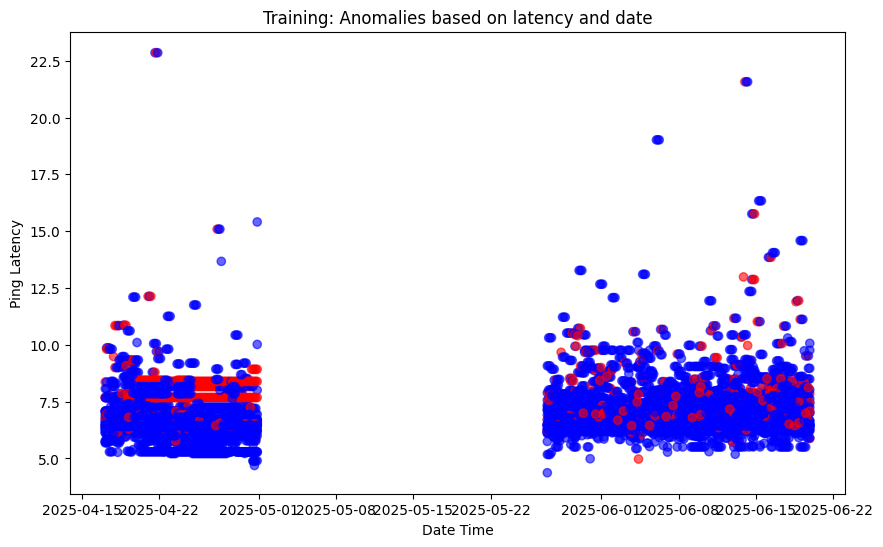

In [23]:
#for host name

plt.figure(figsize=(10, 6))
plt.title(f"Training: Anomalies based on latency and date")
plt.xlabel("Date Time")
plt.ylabel("Ping Latency")
plt.scatter(
    np.array(train_w_lookback["date"]), #may need to index
    np.array(X_train['recent_latency_max']), 
    c=y_train,              # color by labels (1 or -1)
    cmap='bwr',             # blue = reg, red = anomalies
    alpha=0.6
)

# plt.legend()
# plt.savefig(f"plots/latency-date-normalized.png")
plt.show()

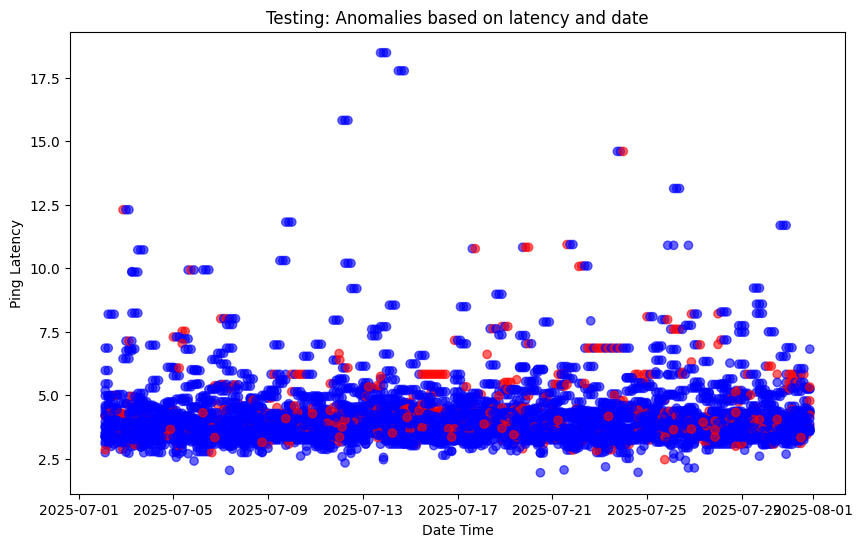

In [440]:
#for host name
plt.figure(figsize=(10, 6))
plt.title(f"Testing: Anomalies based on latency and date")
plt.xlabel("Date Time")
plt.ylabel("Ping Latency")
plt.scatter(
    np.array(test_w_lookback["date"]), #may need to index
    np.array(X_test['recent_latency_max']), 
    c=y_test,              # color by labels (1 or -1)
    cmap='bwr',             # blue = reg, red = anomalies
    alpha=0.6
)

# plt.legend()
# plt.savefig(f"plots/latency-date-normalized.png")
plt.show()

Model Linear Classifier (Logistic Regression): Score 0.6585152838427948, F1 Score 0.5158161497157743, Percent Wrong Pred 0.3414847161572052
Model Nearest Neighbors: Score 0.9124890829694323, F1 Score 0.5336238470575323, Percent Wrong Pred 0.08751091703056768
Model Linear SVM: Score 0.6532751091703056, F1 Score 0.5128160674957534, Percent Wrong Pred 0.3467248908296943
Model RBF SVM: Score 0.6607860262008733, F1 Score 0.5168209474141678, Percent Wrong Pred 0.33921397379912666
Model Decision Tree: Score 0.897117903930131, F1 Score 0.524464176496379, Percent Wrong Pred 0.10288209606986899
Model Random Forest: Score 0.9184279475982533, F1 Score 0.478739870709278, Percent Wrong Pred 0.08157205240174673
Model AdaBoost: Score 0.9187772925764193, F1 Score 0.5033283090130485, Percent Wrong Pred 0.08122270742358079
Model Naive Bayes: Score 0.11109170305676856, F1 Score 0.10874127222917646, Percent Wrong Pred 0.8889082969432315


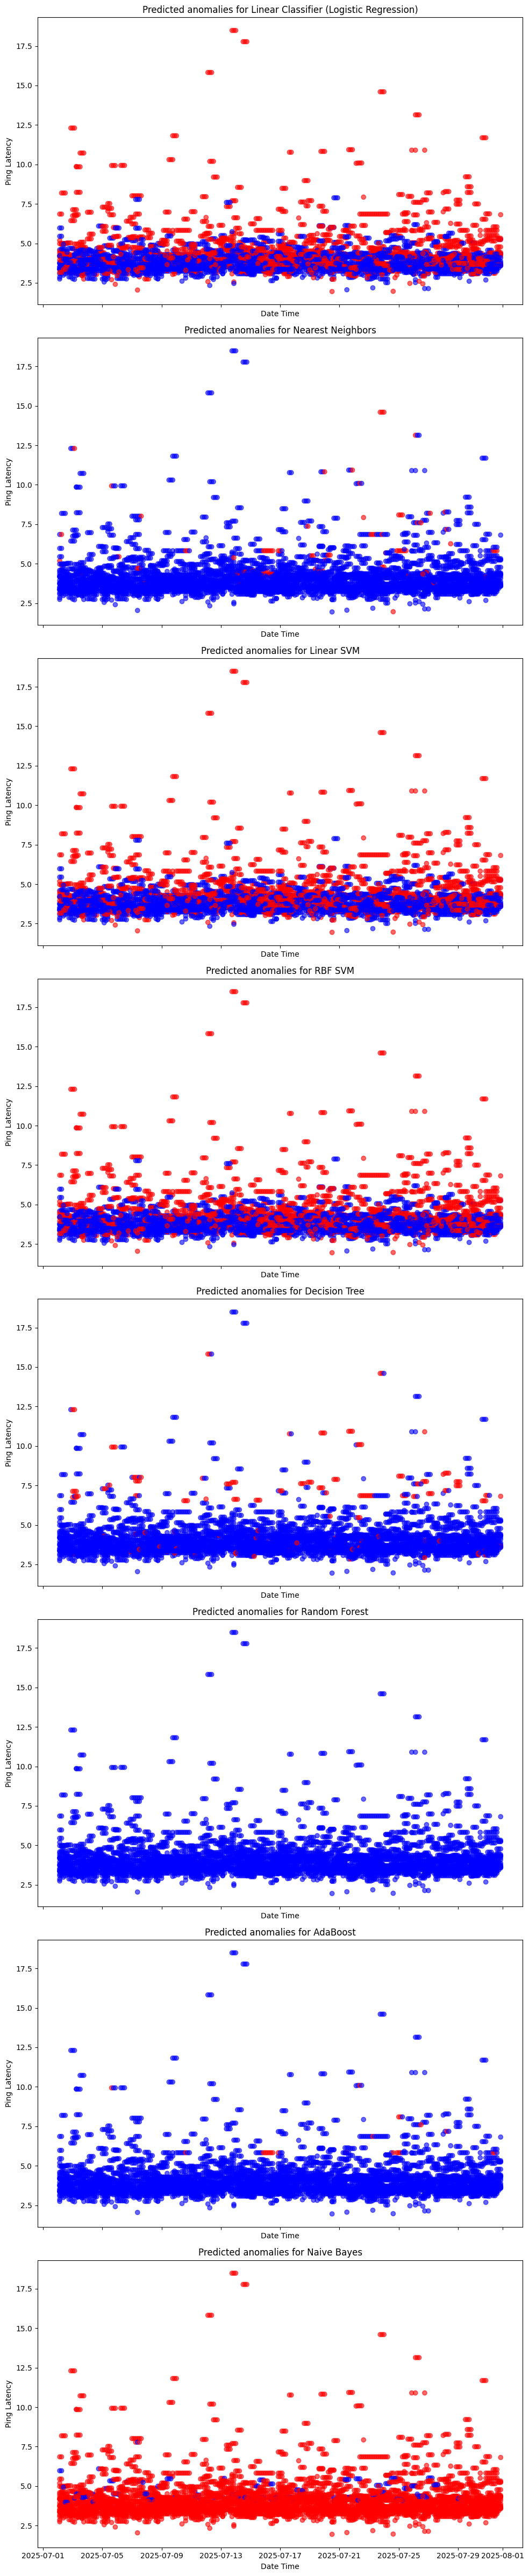

In [441]:
n_models = len(model_dict)
fig, axes = plt.subplots(nrows=n_models, ncols=1, figsize=(10, 6 * n_models), sharex=True)

# if only 1 model, axes is not an array
if n_models == 1:
    axes = [axes]

for ax, (model_name, clf) in zip(axes, model_dict.items()):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    per_wrong = abs(y_pred - y_test).sum() / len(y_test)

    print(f"Model {model_name}: Score {score}, F1 Score {f1}, Percent Wrong Pred {per_wrong}")

    # scatter plot on the current axis
    ax.scatter(
        np.array(test_w_lookback["date"]),  # x-axis
        np.array(X_test["recent_latency_max"]),        # y-axis
        c=y_pred,                # color by predicted label
        cmap='bwr',
        alpha=0.6
    )
    ax.set_title(f"Predicted anomalies for {model_name}")
    ax.set_xlabel("Date Time")
    ax.set_ylabel("Ping Latency")

plt.tight_layout()
plt.show()